In [1]:
import pyedflib as edf
import numpy as np
import glob
import random
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, find_peaks_cwt, find_peaks, periodogram
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Dropout, MaxPooling1D, BatchNormalization
from tensorflow.keras.utils import to_categorical

In [2]:
WINDOW_STEP = 256

files = glob.glob('data/*.edf')
seizure_period_foreach_file = [
     (2996, 3036),
    (1467, 1494),
    (1732, 1772),
    (1015, 1066),
    (4920, 5006),
    (3285, 3381),
    (13688, 13831),
    (2856, 3046),
]

seizure_period_concat_with_file = zip(files, seizure_period_foreach_file)

seizure_period_concat_with_file = [(file_name, start, end) 
                                    for file_name, (start, end) in seizure_period_concat_with_file]

signals = []

for file in files:
    with edf.EdfReader(file) as edf_reader:
        signal_labels = edf_reader.getSignalLabels()
        
        fz_cz_index = signal_labels.index('FZ-CZ')
        cz_pz_index = signal_labels.index('CZ-PZ')
        
        
        buffers = np.zeros((2, edf_reader.getNSamples()[0]))
      
        buffers[0] = edf_reader.readSignal(fz_cz_index)
        buffers[1] = edf_reader.readSignal(cz_pz_index)
        
        
        
        array_buffer = np.array(buffers)
        signals.append(array_buffer)

len(signals)


11

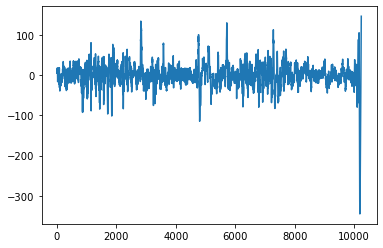

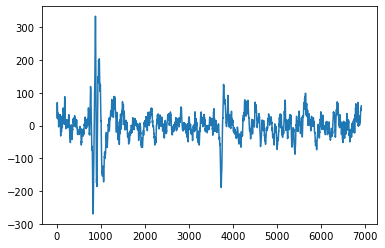

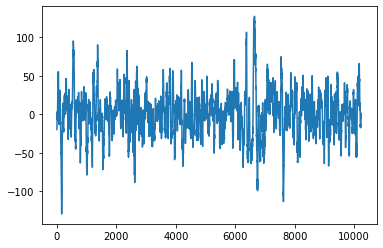

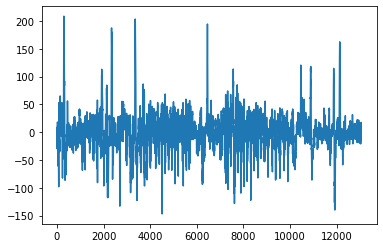

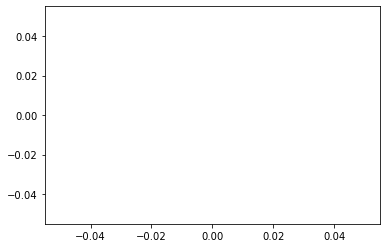

In [3]:
sample_signals = seizure_period_concat_with_file[0:5]

for i, signal in enumerate(sample_signals):
    filename, start, end = signal
    plt.plot(signals[i][0][start * WINDOW_STEP:end * WINDOW_STEP])
    plt.show()

In [4]:
WINDOW_SIZE = 5 * WINDOW_STEP

seizure_signals = np.zeros((0, 2, WINDOW_SIZE))
seizure_y_labels = []

for index in range(len(signals)):
    try:
        start_time = seizure_period_concat_with_file[index][1] * WINDOW_STEP
        end_time = seizure_period_concat_with_file[index][2] * WINDOW_STEP
        for j in range(start_time, end_time, WINDOW_SIZE):
            seizure_signals = np.append(seizure_signals, 
                                        np.array([signals[index][:, j:j + WINDOW_SIZE]]), axis=0)
            seizure_y_labels.append(1)
    except:
        continue

seizure_signals.shape

(91, 2, 1280)

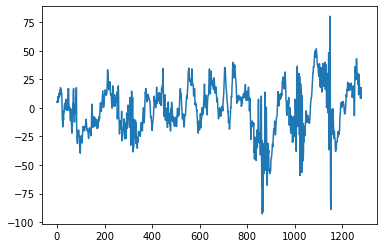

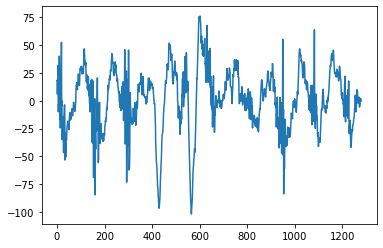

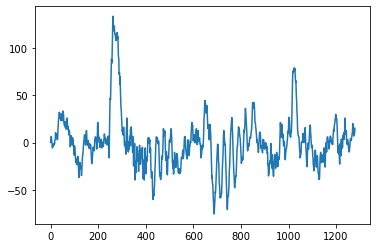

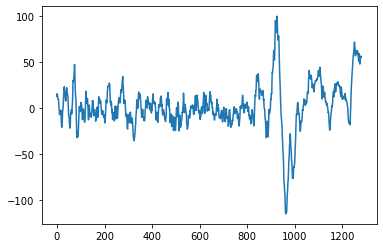

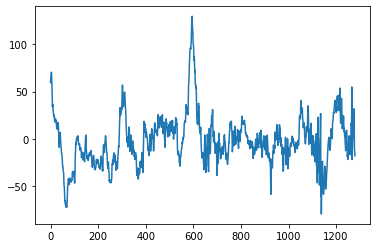

In [5]:
sample_signals = seizure_signals[0:5]

for i in range(len(sample_signals)):
    plt.plot(sample_signals[i][0])
    plt.show()

In [6]:
def remove_noise(signals):
    for index in range(len(signals)):
        low_range = int(0.05 * len(signals[index][0]))
        high_range = int(0.95*len(signals[index][0]))
        signals[index] = signals[index][:,low_range:high_range]

    return signals

signals_without_noise = remove_noise(signals)

len(signals_without_noise)

11

In [7]:
for i in range(len(signals_without_noise)):
    try:
        start_time = seizure_period_concat_with_file[i][1] * WINDOW_STEP
        end_time = seizure_period_concat_with_file[i][2] * WINDOW_STEP
        signals_without_noise[i] = np.delete(signals_without_noise[i], np.s_[start_time:end_time], axis=1)
    except:
        continue

len(signals_without_noise)

11

In [8]:
WINDOW_SIZE = 5 * WINDOW_STEP

non_seizure_signals = np.zeros((0, 2, WINDOW_SIZE))
non_seizure_y_labels = []

for index in range(len(signals_without_noise)):
    try:
        for j in range(WINDOW_STEP):
            random_index = random.randint(0, len(signals_without_noise[i][0]) - WINDOW_SIZE)
            non_seizure_signals = np.append(non_seizure_signals, 
                                        np.array([signals_without_noise[index][:, random_index:random_index + WINDOW_SIZE]]), axis=0)
            non_seizure_y_labels.append(0)
    except:
        continue

non_seizure_signals.shape

(517, 2, 1280)

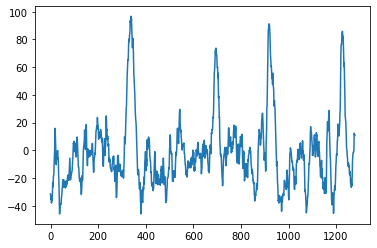

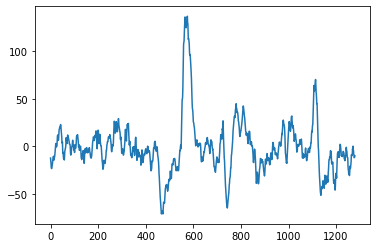

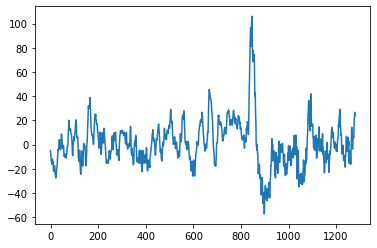

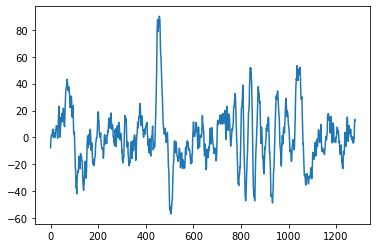

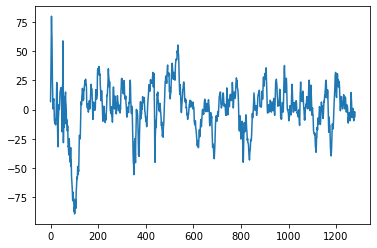

In [9]:
sample_signals = non_seizure_signals[0:5]

for i in range(len(sample_signals)):
    plt.plot(sample_signals[i][0])
    plt.show()


In [10]:
final_signals = np.zeros((0, 2, WINDOW_SIZE))
final_y_labels = []

In [11]:
final_signals = np.append(seizure_signals, non_seizure_signals, axis=0)
final_y_labels = np.append(seizure_y_labels, non_seizure_y_labels, axis=0)

print(final_signals.shape, final_y_labels.shape)

(608, 2, 1280) (608,)


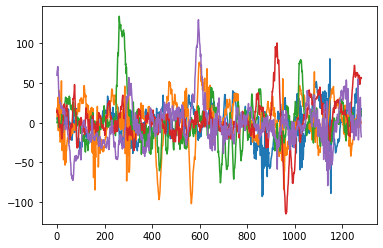

In [12]:
for i in range(len(final_signals[0:5])):
    plt.plot(final_signals[i][0])

plt.show()


In [13]:
def func_var(data):
    return np.var(data, axis=2)

def func_std(data):
    return np.std(data, axis=2)

def func_mean(data):
    return np.mean(data, axis=2)

def func_fft(data):
    return np.fft.fft(data, axis=2)

def func_fft_var(data):
    fft = np.fft.fft(data, axis=2)
    return np.var(fft, axis=2)

def func_fft_std(data):
    fft = np.fft.fft(data, axis=2)
    return np.std(fft, axis=2)

def func_fft_mean(data):
    fft = np.fft.fft(data, axis=2)
    return np.mean(fft, axis=2)

def func_fft2_var(data):
    fft2 = np.fft.fft2(data)
    fft2_abs = np.abs(fft2)
    return np.var(fft2_abs, axis=2)

def func_fft2_std(data):
    fft2 = np.fft.fft2(data)
    fft2_abs = np.abs(fft2)
    return np.std(fft2_abs, axis=2)

def func_fft2_mean(data):
    fft2 = np.fft.fft2(data)
    fft2_abs = np.abs(fft2)
    return np.mean(fft2_abs, axis=2)

def func_power(data):
    return np.sum(np.square(data), axis=2)

# calculate power spectral density for each signal
def func_power_specular_var(data):
    power_specular = np.array([periodogram(data[index, :])[1] for index in range(data.shape[0])])
    return np.var(power_specular, axis=2)

def func_power_specular_std(data):
    power_specular = np.array([periodogram(data[index, :])[1] for index in range(data.shape[0])])
    return np.var(power_specular, axis=2)

def func_power_specular_mean(data):
    power_specular = np.array([periodogram(data[index, :])[1] for index in range(data.shape[0])])
    return np.var(power_specular, axis=2)

def func_complexity(data):
    fft = np.fft.fft(data)
    return np.sum(np.square(np.abs(np.diff(fft, axis=2))), axis=2)

def func_zero_crossing_rate(data):
    return np.sum(np.abs(np.diff(np.sign(data), axis=2)), axis=2)

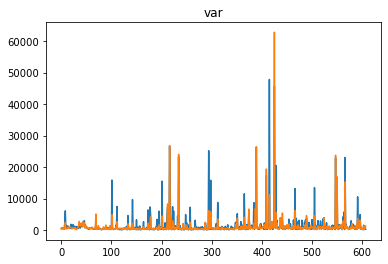

In [14]:
var = func_var(final_signals)

plt.title('var')
plt.plot(var)
plt.show()

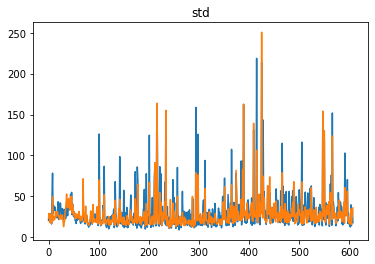

In [15]:
std = func_std(final_signals)

plt.title('std')
plt.plot(std)
plt.show()

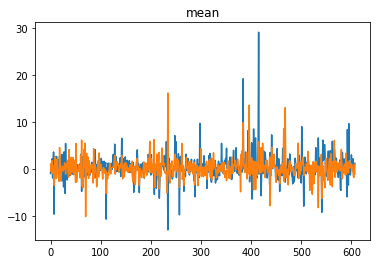

In [16]:
mean = func_mean(final_signals)

plt.title('mean')
plt.plot(mean)
plt.show()


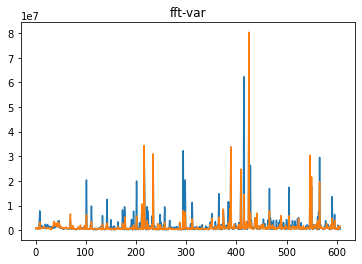

In [17]:
fft_var = func_fft_var(final_signals)

plt.title('fft-var')
plt.plot(fft_var)
plt.show()


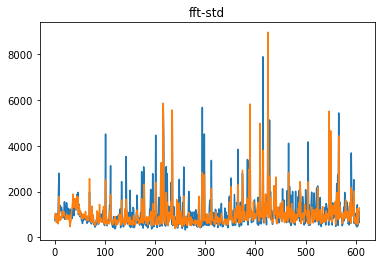

In [18]:
fft_std = func_fft_std(final_signals)

plt.title('fft-std')
plt.plot(fft_std)
plt.show()

/Users/kavish/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


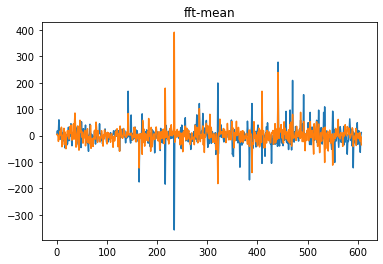

In [19]:
fft_mean = func_fft_mean(final_signals)

plt.title('fft-mean')
plt.plot(fft_mean)
plt.show()

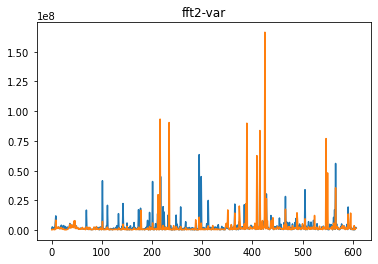

In [20]:
fft2_var = func_fft2_var(final_signals)

plt.title('fft2-var')
plt.plot(fft2_var)
plt.show()

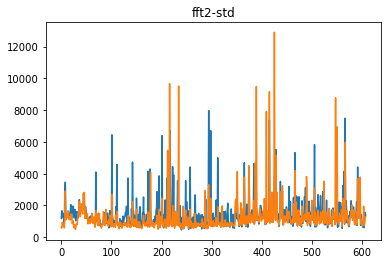

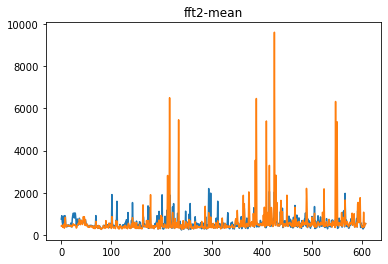

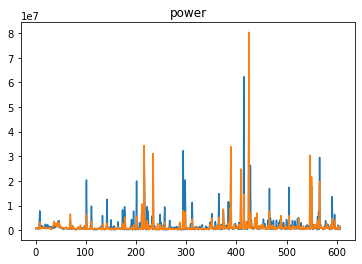

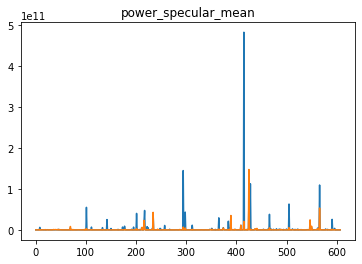

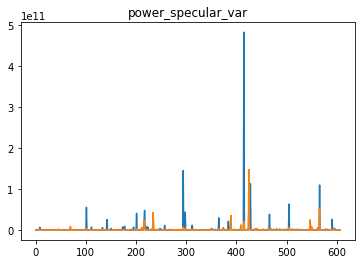

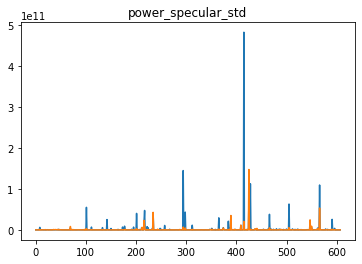

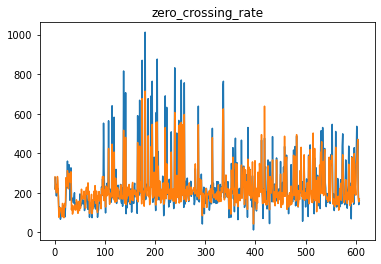

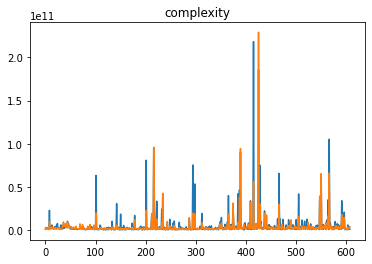

In [21]:
fft2_std = func_fft2_std(final_signals)
plt.title('fft2-std')
plt.plot(fft2_std)
plt.show()

fft2_mean = func_fft2_mean(final_signals)
plt.title('fft2-mean')
plt.plot(fft2_mean)
plt.show()


power = func_power(final_signals)
plt.title('power')
plt.plot(power)
plt.show()

power_specular_mean = func_power_specular_mean(final_signals)
plt.title('power_specular_mean')
plt.plot(power_specular_mean)
plt.show()

power_specular_var = func_power_specular_var(final_signals)
plt.title('power_specular_var')
plt.plot(power_specular_var)
plt.show()

power_specular_std = func_power_specular_std(final_signals)
plt.title('power_specular_std')
plt.plot(power_specular_std)
plt.show()

zero_crossing_rate = func_zero_crossing_rate(final_signals)
plt.title('zero_crossing_rate')
plt.plot(zero_crossing_rate)
plt.show()

complexity = func_complexity(final_signals)
plt.title('complexity')
plt.plot(complexity)
plt.show()


In [22]:
features = np.concatenate((var
                          ,std
                          ,mean
                          ,fft_var
                          ,fft_std
                          ,fft2_var
                          ,fft2_std
                          ,fft2_mean
                          ,power
                          ,power_specular_var
                          ,power_specular_std
                          ,power_specular_mean
                          ,zero_crossing_rate
                          ,complexity), axis=1)

features.shape

(608, 28)

0.8032786885245902
[[98  0]
 [24  0]]


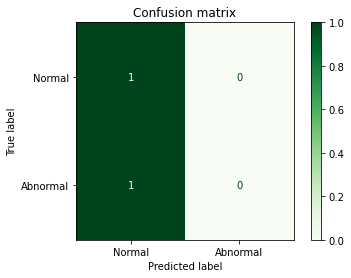

In [23]:
x_train, x_test, y_train, y_test = train_test_split(features, final_y_labels, test_size=0.2, random_state=42)

clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)

clf.fit(x_train, y_train)

y_prediction = clf.predict(x_test)

print(accuracy_score(y_test, y_prediction))

print(confusion_matrix(y_test, y_prediction))

display = plot_confusion_matrix(clf, x_test, y_test, display_labels=['Normal', 'Abnormal'], cmap=plt.cm.Greens, normalize='true')
display.ax_.set_title('Confusion matrix')
plt.show()

In [24]:
x_train, x_test, y_train, y_test = train_test_split(final_signals, final_y_labels, test_size=0.2, random_state=42)

y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)

In [25]:
KERNEL_SIZE = 5
FILTER_SIZE = 256
POOL_SIZE = 2
DROPOUT = 0.3
DENSE_1 = 256
DENSE_2 = 2

sequential = Sequential()

sequential.add(Conv1D(filters=FILTER_SIZE
                     ,kernel_size=KERNEL_SIZE
                     ,activation='relu'
                     ,input_shape=(WINDOW_SIZE, 2)))
sequential.add(MaxPooling1D(pool_size=POOL_SIZE))
sequential.add(Dropout(DROPOUT))

sequential.add(Conv1D(filters=FILTER_SIZE / 2
                     ,kernel_size=KERNEL_SIZE
                     ,activation='relu'))
sequential.add(MaxPooling1D(pool_size=POOL_SIZE))
sequential.add(Dropout(DROPOUT))

sequential.add(Conv1D(filters=FILTER_SIZE / 4
                     ,kernel_size=KERNEL_SIZE
                     ,activation='relu'))
sequential.add(MaxPooling1D(pool_size=POOL_SIZE))
sequential.add(Dropout(DROPOUT))

sequential.add(Flatten())

#add our features to the last fully connected layer

sequential.add(Dense(DENSE_1, activation='relu'))
sequential.add(Dense(DENSE_2, activation='softmax'))

sequential.summary()

sequential.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1276, 256)         2816      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 638, 256)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 638, 256)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 634, 128)          163968    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 317, 128)         0         
 1D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 317, 128)          0

In [26]:
x_train = x_train.reshape(x_train.shape[0], WINDOW_SIZE, 2).astype('float32')
x_test = x_test.reshape(x_test.shape[0], WINDOW_SIZE, 2).astype('float32')
sequential.fit(x_train, y_train_categorical, epochs=10, shuffle=True, verbose=2)


Epoch 1/10
16/16 - 12s - loss: 5.6006 - accuracy: 0.7819 - 12s/epoch - 780ms/step
Epoch 2/10
16/16 - 12s - loss: 0.4729 - accuracy: 0.8621 - 12s/epoch - 722ms/step
Epoch 3/10
16/16 - 12s - loss: 0.4441 - accuracy: 0.8601 - 12s/epoch - 723ms/step
Epoch 4/10
16/16 - 12s - loss: 0.4293 - accuracy: 0.8621 - 12s/epoch - 720ms/step
Epoch 5/10
16/16 - 12s - loss: 0.3870 - accuracy: 0.8621 - 12s/epoch - 747ms/step
Epoch 6/10
16/16 - 12s - loss: 0.3715 - accuracy: 0.8621 - 12s/epoch - 728ms/step
Epoch 7/10
16/16 - 12s - loss: 0.3505 - accuracy: 0.8621 - 12s/epoch - 749ms/step
Epoch 8/10
16/16 - 12s - loss: 0.3404 - accuracy: 0.8621 - 12s/epoch - 722ms/step
Epoch 9/10
16/16 - 12s - loss: 0.3150 - accuracy: 0.8663 - 12s/epoch - 743ms/step
Epoch 10/10
16/16 - 13s - loss: 0.2864 - accuracy: 0.8601 - 13s/epoch - 829ms/step


In [27]:
model_loss, model_accuracy = sequential.evaluate(x_test, y_test_categorical, verbose=2)
print(f"CNN - Loss: {model_loss}, Accuracy: {model_accuracy}")

4/4 - 1s - loss: 0.5248 - accuracy: 0.8033 - 1s/epoch - 280ms/step
CNN - Loss: 0.5248450636863708, Accuracy: 0.8032786846160889


In [28]:
y_prediction = sequential.predict(x_test)
y_prediction = np.argmax(y_prediction, axis=1)
y_test = np.argmax(y_test_categorical, axis=1)
print(classification_report(y_test, y_prediction))

4/4 [==============================] - 1s 209ms/step
              precision    recall  f1-score   support

           0       0.80      1.00      0.89        98
           1       0.00      0.00      0.00        24

    accuracy                           0.80       122
   macro avg       0.40      0.50      0.45       122
weighted avg       0.65      0.80      0.72       122



/Users/kavish/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kavish/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kavish/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [29]:

sequential.save("model")

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


In [77]:
import pyedflib as edf
import numpy as np

f = edf.EdfReader('data/chb01_16.edf')
n = f.signals_in_file
features = []
#for i in range(n):
 #   signal = f.readSignal(i)
  #  features.append(signal)
signal_labels2 = f.getSignalLabels()
fz_cz_index = signal_labels2.index('FZ-CZ')
cz_pz_index = signal_labels2.index('CZ-PZ')
buffers = np.zeros((2, f.getNSamples()[0]))
buffers[0] = f.readSignal(fz_cz_index)
buffers[1] = f.readSignal(cz_pz_index)
array_buffer = np.array(buffers)
features.append(array_buffer)
 
from tensorflow.keras.models import load_model
loaded_model = load_model("model")
X = np.array(features).reshape(-1,1280,2)

# Predict the probabilities for each class
probs = loaded_model.predict(X)
print(probs)
# Apply a threshold of 0.5 to obtain binary predictions
binary_preds = (probs[:, 0] >= 0.75).astype(int)
print(binary_preds[0])
# Print the binary predictions
print(sum(binary_preds), len(binary_preds))
if(sum(binary_preds)/len(binary_preds)<=0.87):
    print("Seizure")
else:
    print("No Seizure")
f.close()

23/23 [==============================] - 5s 225ms/step
[[0.9492452  0.0507548 ]
 [0.9670931  0.0329069 ]
 [0.94672173 0.05327827]
 ...
 [0.8606103  0.13938966]
 [0.69329816 0.30670187]
 [0.79890394 0.20109601]]
1
576 720
Seizure
